# Mini-projet: Traitement des signaux de parole #

L’objectif de ce mini-projet est d’implémenter, de manière simplifiée, des modèles utilisés pour traiter les signaux de parole en téléphonie cellulaire.

In [1005]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wavfile
from scipy.signal import resample, lfilter
from scipy.signal.windows import hann
from scipy.linalg import solve_toeplitz, toeplitz

from math import *

import utils

fs = 8e3  # sampling frequency

## Fenêtrage du signal

In [1006]:
#  window
w = hann(floor(0.02*sample_rate), False) + 0.001

In [1007]:
def blocks_decomposition(x, w, R=0.5):
    """
    Performs the windowing of the signal

    Parameters
    ----------

    x: numpy array
      single channel signal
    w: numpy array
      window
    R: float (default: 0.5)
      overlapping between subsequent windows
      unité ? %

    Return
    ------

    out: numpy array
      block decomposition of the signal
    """

    # nombre d'instants séparant le début de 2 blocs consécutifs,
    interval = int(w.size * R)
    # correspondant à la moitié de la taille de la fenêtre si R=0.5

    # signal étendu pour fenêtrer le dernier morceau plus court que la fenêtre
    x_ext = np.pad(x, (0, interval))

    blocks = np.zeros(shape=(x.size // interval, w.size))

    for k in range(blocks.shape[0]):
        blocks[k, :] = x_ext[k * interval: k * interval + w.size] * w
        # utils.plot_signal(blocks[k, :],fs)

    return blocks


In [1008]:

def blocks_reconstruction(blocks, w, signal_size, R=0.5):
    """
    Reconstruct a signal from overlapping blocks

    Parameters
    ----------

    blocks: numpy array
      signal segments. blocks[i,:] contains the i-th windowed
      segment of the speech signal
    w: numpy array
      window
    signal_size: int
      size of the original signal
    R: float (default: 0.5)
      overlapping between subsequent windows

    Return
    ------

    out: numpy array
      reconstructed signal
    """
    
    interval = int(w.size * (1-R))
    # étendu avec des 0 pour fenêtrer la fin du signal réel
    f_ext = np.zeros(signal_size + w.size, dtype=float)

    for k in range(blocks.shape[0]):
        decoded_block = blocks[k] / w
        f_ext[k*interval: k*interval + w.size] += decoded_block
        # utils.plot_signal(f_ext,fs)

    f = f_ext[:signal_size]  # on enlève les 0 ajoutés au bord
    # on moyenne les intervalles d'instants où il y a overlap
    f[interval: blocks.shape[0] * interval] *= R

    return f

## Encodage des segments ##

Commençons par implanter l'estimation des coefficients du filtre pour un segment de parole en codant la fonction `lpc_encode` en utilisant la fonction `solve_toeplitz` de la libraire `scipy` tel que suggéré dans l'énoncé. Implantons deux autres fonctions auxiliaires qui vont être utiles dans la suite du projet : `convolve` qui effectue le produit de convolution entre deux signaux avec un nombre prédéfini de termes ainsi que `autocovariance`.

In [1009]:
def autocovariance(x, k):
    """
    Estimates the autocovariance C[k] of signal x

    Parameters
    ----------
    x: numpy array
        Speech segment to be encoded.
    k: int
        Covariance index.
    """
    N = len(x)
    if k >= N:
        return 0.0

    x_mean = np.mean(x)
    cov = 0.0
    for n in range(N - k):
        cov += (x[n] - x_mean) * (x[n + k] - x_mean)

    return cov / N


In [1010]:
def convolve(a, b, n):
    """
    evaluate convolution of a and b in n
    a: numpy array
    b: numpy array
      assumed that b.size >= a.size
    """

    return np.array([a[k] * b[n - 1 - k] for k in range(min(a.size, n))]).sum()

def lpc_encode(x, p):
    """
    Linear predictive coding 

    Predicts the coefficient of the linear filter used to describe the 
    vocal track

    Parameters
    ----------

    x: numpy array
      segment of the speech signal
    p: int
      number of coefficients in the filter
      musts be < x.size ?

    Returns
    -------

    out: tuple (coef, prediction)
      coefs: numpy array
        filter coefficients
      prediction: numpy array
        lpc prediction
    """
    # v_acov = np.vectorize(lambda k: autocovariance(x, k))
    v_acov = np.vectorize(lambda k: autocovariance(x, k))

    alphas = solve_toeplitz(c_or_cr=v_acov(
        np.arange(p)), b=v_acov(np.arange(1, p+1)))

    x_estim = np.zeros(x.size, dtype=float)  # estimations du signal fenêtré
    x_estim[0] = x[0]
    for n in range(1, x.size):
        x_estim[n] = convolve(alphas, x, n)

    return alphas, x_estim


In [1011]:
def lpc_decode(coefs, source):
    """
    Synthesizes a speech segment using the LPC filter and an excitation source

    Parameters
    ----------

    coefs: numpy array
      filter coefficients

    source: numpy array
      excitation signal

    Returns
    -------

    out: numpy array
      synthesized segment
    """
    s = np.zeros(source.size, dtype=float)
    s[0] = source[0]
    for n in range(1, s.size):
        s[n] = source[n] + convolve(coefs, s, n)

    return s


## Estimation du pitch

Implantons maintenant la fonction `compute_cepstrum` en utilisant la méthode décrite dans l'énoncé.

In [1012]:
def compute_cepstrum(x):
    """
    Computes the cepstrum of the signal

    Parameters
    ----------

    x: numpy array
      signal

    Return
    ------

    out: numpy array
      signal cepstrum
    """
    log_norm_dft_s = np.log(np.abs(np.fft.fft(x)))
    x_cepstrum = np.fft.ifft(log_norm_dft_s)

    return x_cepstrum

In [1013]:
def create_impulse_train(sample_rate, L: float, T: float) -> np.array:
    """
    create train of M dirac impulsions of duration L sampled at the frequency sample_rate and with a pitch of T (s)
    """
    size = int(L * sample_rate)  # nb of elts in array
    M = int(L / T) # number of emissions
    ind_bet_pitches = int(T * fs)  # nb indices entre 2 émissions de pitch
    e = np.zeros(size, dtype=float)
    for k in range(M):
        e[k * ind_bet_pitches] = 1.

    return e

In [1014]:
def cepstrum_pitch_detection(cepstrum, threshold = 2, min_rate = 50, max_rate=250, sample_rate = 8e3):
    """
    Cepstrum based pitch detection

    Parameters
    ----------

    cepstrum: numpy array
      cepstrum of the signal segment
    threshold: float 
      threshold used to distinguish between voiced/unvoiced segments
    max_rate: float
      maximal pitch frequency
    sample_rate: float
      sample rate of the signal

    Return
    ------

    out: int
      estimated pitch. For an unvoiced segment, the pitch is set to zero
    """
    
    # we keep the cepstrum content only between these indices
    init_ind = int(sample_rate / max_rate) 
    end_ind = int(sample_rate / min_rate)
    # # we keep the half to avoid aliasing
    end_ind2 = len(cepstrum) // 2
    
    # end_ind = min(int(sample_rate / min_rate), len(cepstrum) // 2)
    # segmented absolute value of cepstrum
    seg_abs_ceps = np.abs(cepstrum[init_ind:end_ind2])  

    maxi = np.max(seg_abs_ceps)
    mean = np.mean(seg_abs_ceps)

    # important to add initial indice
    ind_pitch = init_ind + np.argmax(seg_abs_ceps)

    if  maxi / mean > threshold and ind_pitch < end_ind:
        pitch_estim =  ind_pitch / sample_rate
    else:
        pitch_estim = 0.

    return pitch_estim


In [1015]:
"""
LPC encoding
"""

[sample_rate, speech] = wavfile.read('./audio/speech.wav')
# speech = np.array(speech)

# tests sur un segment seulement
speech = np.array(speech)

# normalize the speech
speech = 0.9*speech/max(abs(speech))

# utils.plot_signal(speech, fs)

# resampling to 8kHz
target_sample_rate = 8000
target_size = int(len(speech)*target_sample_rate/sample_rate)
speech = resample(speech, target_size)
sample_rate = target_sample_rate

# Record resampled signal
wavfile.write("./results/speech_resampled.wav", sample_rate, speech)


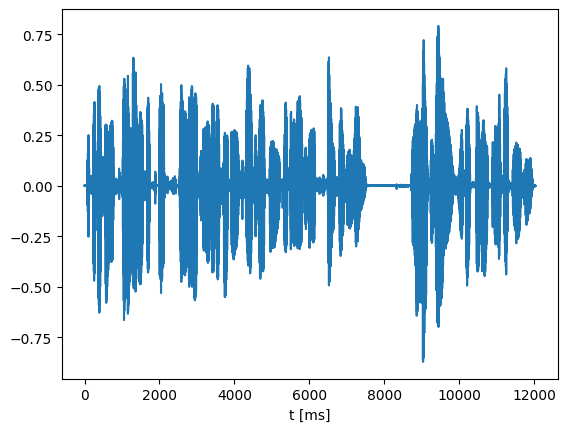

In [1016]:
utils.plot_signal(speech, sample_rate)

In [1017]:
# Block decomposition
blocks = blocks_decomposition(speech, w, R = 0.5)
n_blocks, block_size = blocks.shape
n_blocks, block_size

(1203, 160)

In [1018]:
rec_sign = blocks_reconstruction(blocks, w, speech.size, R=0.5)

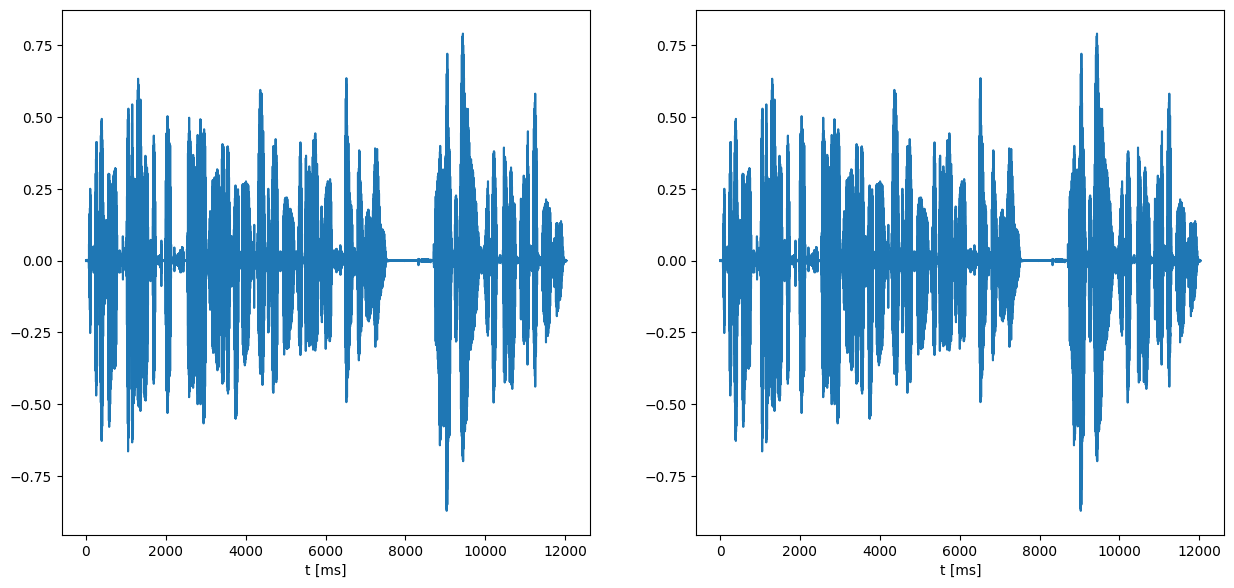

In [1019]:
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
utils.plot_signal(speech, sample_rate)
plt.subplot(2,2,2)
utils.plot_signal(rec_sign, sample_rate)

In [1020]:
np.max(np.abs(rec_sign - speech))

1.1102230246251565e-16

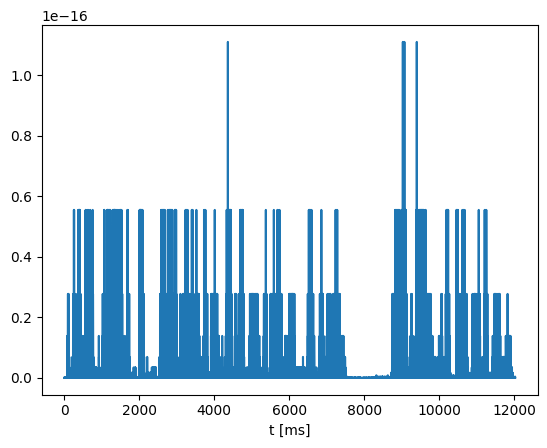

In [1021]:
utils.plot_signal(np.abs(rec_sign - speech),sample_rate)

In [1022]:
# --------------------
# Encoding
# --------------------

p = 32 # LPC filter: number of coefficients
threshold = 2 # Parameters for pitch detection
min_rate = 50 # Minimal pitch frequency [Hz]
max_rate = 250 # Maximal pitch frequency [Hz]

In [1023]:
lpc_coefs, pitches, gain, errors, predictions, cepstrums = [], [], [], [], [], []
for block in blocks:

    # Linear predictive coding
    coefs, prediction = lpc_encode(block, p)

    error = block - prediction
    
    # Pitch detection
    cepstrum = compute_cepstrum(block)

    pitch = cepstrum_pitch_detection(cepstrum, threshold, min_rate, max_rate,sample_rate)     
    
    # Update
    lpc_coefs.append(coefs)
    pitches.append(pitch)
    gain.append(np.std(error)) # standard deviation of residue
    errors.append(error)
    predictions.append(prediction)
    cepstrums.append(cepstrum)
    

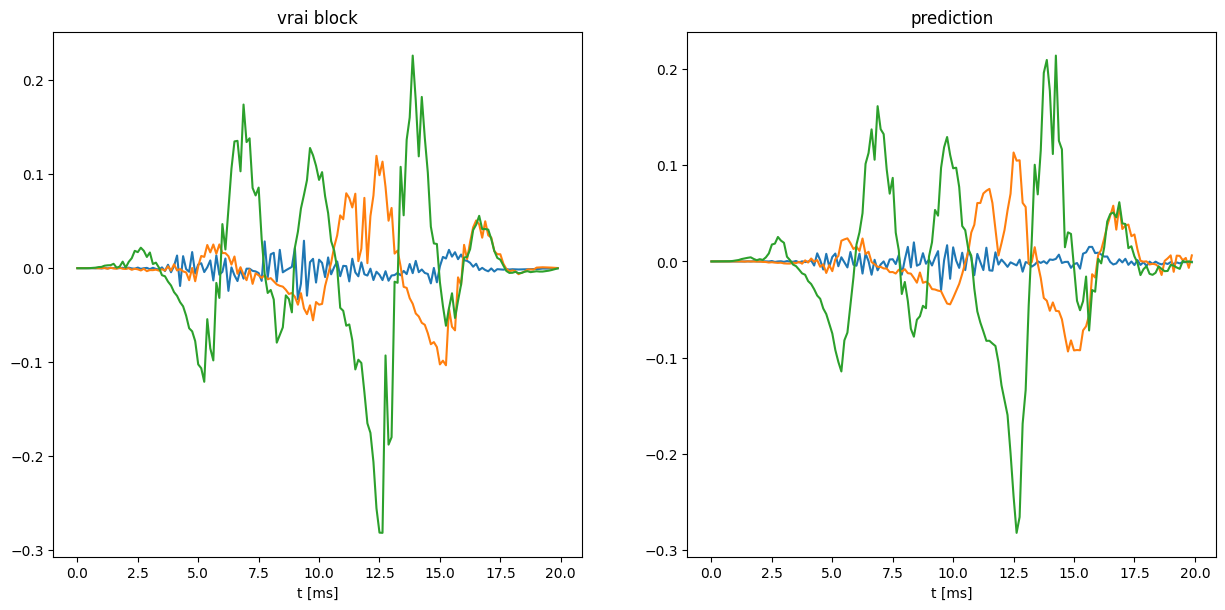

In [1024]:
plt.figure(figsize=(15,15))
nb_plots = 3
start = 100
for i in range(start,start + nb_plots):
    plt.subplot(2,2,1)
    plt.title('vrai block')
    utils.plot_signal(blocks[i],sample_rate)
    plt.subplot(2,2,2)
    plt.title('prediction')
    utils.plot_signal(predictions[i],sample_rate)


In [1025]:
pitches

[0.00425,
 0.004125,
 0.005,
 0.00625,
 0.005,
 0.004,
 0.007375,
 0.0055,
 0.004375,
 0.00775,
 0.00775,
 0.005,
 0.005375,
 0.004625,
 0.00575,
 0.007625,
 0.005375,
 0.004125,
 0.006,
 0.00625,
 0.004875,
 0.005,
 0.005875,
 0.006625,
 0.004875,
 0.007,
 0.007125,
 0.004,
 0.005,
 0.004875,
 0.0055,
 0.00425,
 0.006625,
 0.004375,
 0.005875,
 0.005625,
 0.0055,
 0.005625,
 0.00575,
 0.00575,
 0.00575,
 0.00575,
 0.005875,
 0.005625,
 0.004875,
 0.00725,
 0.005,
 0.005125,
 0.0045,
 0.00475,
 0.006625,
 0.00525,
 0.004125,
 0.004625,
 0.0055,
 0.007125,
 0.0075,
 0.00775,
 0.005,
 0.0085,
 0.00875,
 0.009125,
 0.00675,
 0.007,
 0.0075,
 0.004875,
 0.009625,
 0.007125,
 0.00475,
 0.009875,
 0.007625,
 0.00675,
 0.006625,
 0.004125,
 0.0055,
 0.006625,
 0.00425,
 0.0065,
 0.004625,
 0.00475,
 0.0055,
 0.0045,
 0.005625,
 0.00525,
 0.005625,
 0.0065,
 0.00425,
 0.00475,
 0.00625,
 0.005125,
 0.009125,
 0.004375,
 0.004875,
 0.006125,
 0.0045,
 0.004,
 0.00525,
 0.00675,
 0.0045,
 0.0077

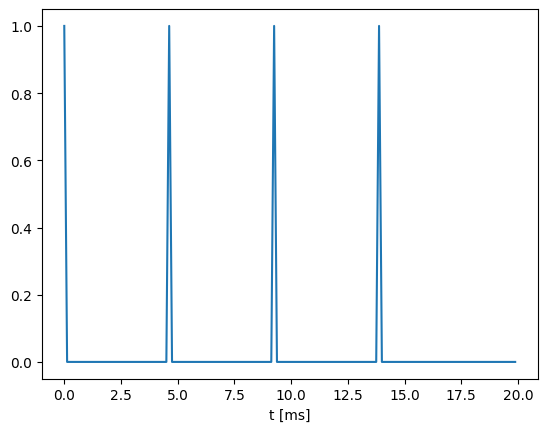

In [1026]:
e=create_impulse_train(8e3, 160 / 8e3, 0.0047)
utils.plot_signal(e,fs)

In [1035]:
gain

array([5.17838840e-06, 6.11505022e-06, 6.29400273e-06, ...,
       6.75416098e-06, 5.28252753e-06, 6.09536670e-06])

In [1027]:
gain = 1e3 * np.array(gain)

In [1028]:

# --------------------
# Decoding
# --------------------

blocks_decoded, sources = [], []
for coefs, pitch, g in zip(lpc_coefs, pitches, gain):

    # Creates an excitation signal for a non-voiced speech
    # the noise must have g as standard deviation
    noise = g * np.random.randn(block_size) 

    if(pitch != 0.):
    
        # create an excitation signal based upon a train of
        # impulses of the same length as the current block        
        source = create_impulse_train(sample_rate, block_size / sample_rate, pitch)

        # the source must have g as standard deviation
        sigma = np.std(source)
        if sigma != 0:
            source *= ( g / sigma)

        
        
    else:
        source = noise

    

    block_decoded = lpc_decode(coefs, w*source)

    blocks_decoded.append(block_decoded)
    sources.append(source)



In [1029]:
np.max([np.max(source) for source in sources])

0.0249147233182768

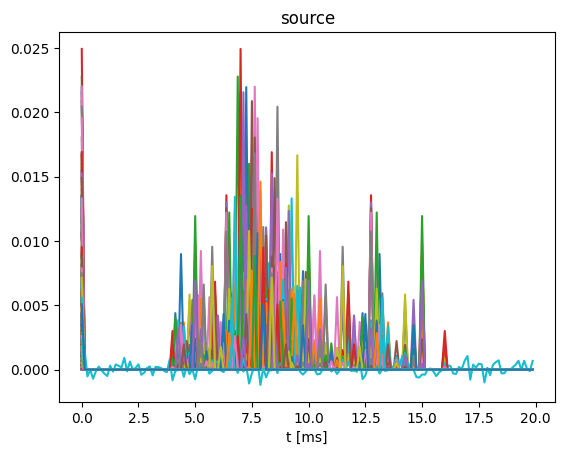

In [1030]:
nb_plots = int( speech.size / block_size )
start = 100

plt.title('source')
for i in range(start,start + nb_plots):
    utils.plot_signal(sources[i],sample_rate)

In [1031]:
blocks_decoded = np.array(blocks_decoded) 

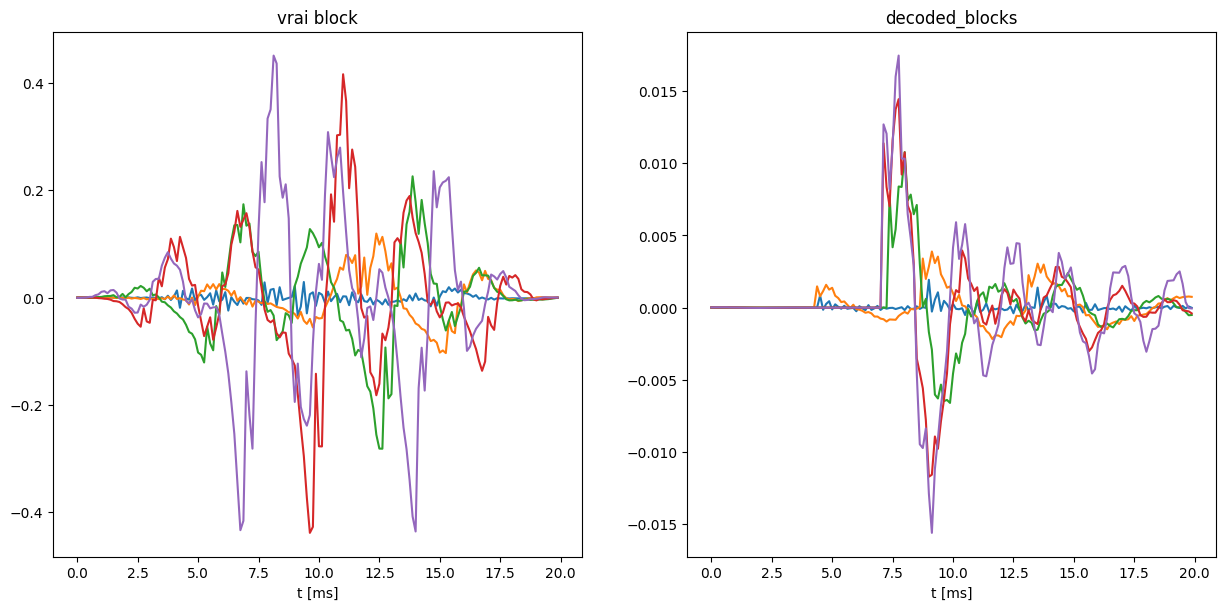

In [1032]:
nb_plots = 5
start = 100

plt.figure(figsize=(15,15))
start = 100
for i in range(start,start + nb_plots):
    plt.subplot(2,2,1)
    plt.title('vrai block')
    utils.plot_signal(blocks[i],sample_rate)
    plt.subplot(2,2,2)
    plt.title('decoded_blocks')
    utils.plot_signal(blocks_decoded[i],sample_rate)

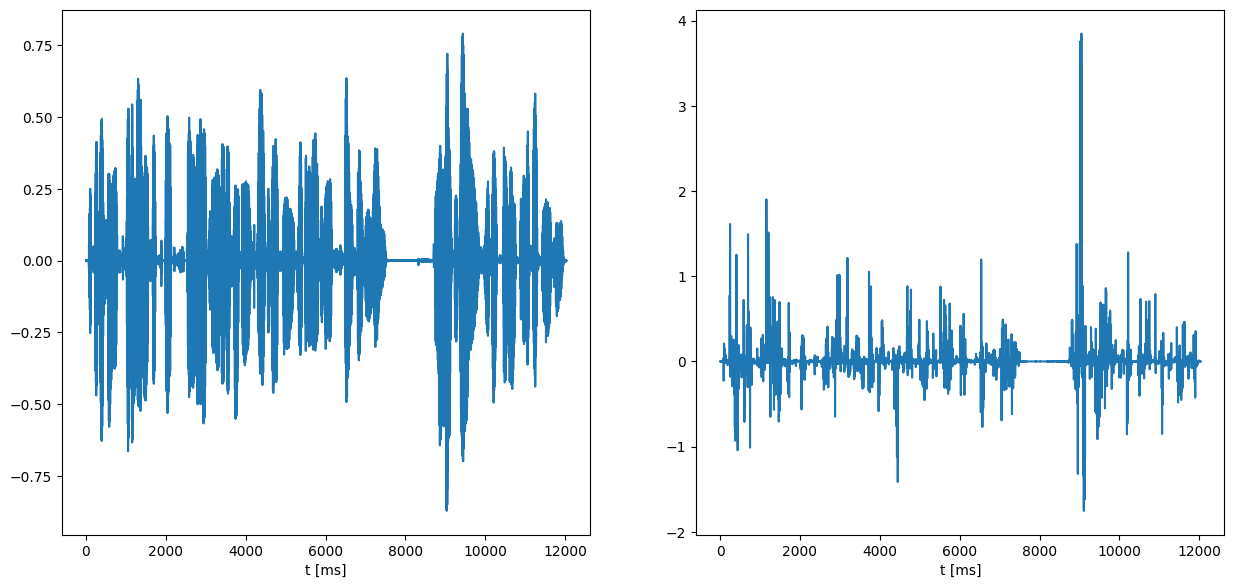

In [1033]:
decoded_speech = blocks_reconstruction(blocks_decoded, w, speech.size, 
    R = 0.5)
    
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
utils.plot_signal(speech, sample_rate)
plt.subplot(2,2,2)
utils.plot_signal(decoded_speech, sample_rate)


In [ ]:
gros problème de gain

In [1034]:
wavfile.write("./results/decoded_speech.wav", sample_rate, decoded_speech)